## Предобработка данных

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd

In [3]:
# Загрузим набор данных

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [4]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [0]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Перекодируем переменные типа `object` с помощью числовых значений

In [0]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [7]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [8]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [9]:
1 - 0.9906

0.009399999999999964

Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

**NB**: В H2O не рекомендуется использовать one-hot encoding, поскольку данный фреймворк корректно работает с категориальными признаками, тогда как применение one-hot encoding приводит к неэффективности. Тем не менее, используем здесь фиктивные переменные, чтобы в дальнейшем сохранить возможность сравнения результатов построенных моделей.

In [10]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [11]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [12]:
df['SocioCateg'].unique()

array(['CSP50', 'CSP55', 'CSP60', 'CSP48', 'CSP6', 'CSP66', 'CSP1',
       'CSP46', 'CSP21', 'CSP47', 'CSP42', 'CSP37', 'CSP22', 'CSP3',
       'CSP49', 'CSP20', 'CSP2', 'CSP40', 'CSP7', 'CSP26', 'CSP65',
       'CSP41', 'CSP17', 'CSP57', 'CSP56', 'CSP38', 'CSP51', 'CSP59',
       'CSP30', 'CSP44', 'CSP61', 'CSP63', 'CSP45', 'CSP16', 'CSP43',
       'CSP39', 'CSP5', 'CSP32', 'CSP35', 'CSP73', 'CSP62', 'CSP52',
       'CSP27', 'CSP24', 'CSP19', 'CSP70'], dtype=object)

In [0]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [14]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [0]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

Теперь, когда большинство переменных типа `object` обработаны, исключим их из набора данных за ненадобностью.

In [0]:
df = df.select_dtypes(exclude=['object'])

Также создадим такую переменную, как квадрат возраста.

In [17]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,0,1,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,1,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1,0,0,0,0,0,0,0,0,1,0,3249


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [0]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [19]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [20]:
import plotly.express as px
fig = px.scatter(df, x='ClaimsCount', y='ClaimAmount', title='Зависимость между частотой и величиной убытков')
fig.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [0]:
dfAC = df[df.ClaimsCount > 0].copy()
dfAC['AvgClaim'] = dfAC.ClaimAmount/dfAC.ClaimsCount

In [22]:
dfAC.loc[:, ['ClaimAmount', 'ClaimsCount', 'AvgClaim']]

,ClaimAmount,ClaimsCount,AvgClaim
33,5377.204532,4.0,1344.301133
34,2017.843505,2.0,1008.921752
53,356.773414,2.0,178.386707
65,645.125982,1.0,645.125982
66,1200.422356,2.0,600.211178
...,...,...,...
115085,230.736254,2.0,115.368127
115138,1562.356495,3.0,520.785498
115142,476.318429,3.0,158.772810
115148,1117.886103,1.0,1117.886103


## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [0]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(dfAC.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'AvgClaim'], axis=1), dfAC.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

## Обобщенные линейные модели (Generalized Linear Models, GLM)

### Теория

Пусть $y$ – целевая переменная, $X$ – матрица объясняющих переменных, $\beta$ – вектор параметров модели.

Матрица $X$ составлена из всех векторов наблюдений $x_i$, каждый из которых представляет собой объясняющую переменную.

Основные компоненты обобщенной линейной модели:
* Систематическая компонента $\eta$:
    * $\eta = X\beta \hspace{10pt}(=\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_nx_n)$.
* Случайная компонента $y$:
    * Элементы вектора $y$ – независимые одинаково распределенные случайные величины, имеющие функцию плотности распределения $f(y;\theta,\phi)$ из экспоненциального семейства.
    * Распределения из экспоненциального семейства имеют параметры $\theta$ (характеристика среднего) и $\phi$ (характеристика дисперсии). В общем виде данные распределения могут быть определены:
    $$f_i(y_i;\theta_i,\phi)=\exp\left\lbrace \frac{y_i\theta_i-b(\theta_i)}{a_i(\phi)} + c(y_i, \phi) \right\rbrace,$$
    где $a_i(\phi)$, $b(\theta_i)$ и $c(y_i, \phi)$ некоторые функции.
    * Для распределений из данного семейства дисперсия является функцией от среднего.
    * Экспоненциальное семейство включает распределения нормальное, экспоненциальное, Пуассона, гамма, хи-квадрат, бета и другие.
* Функция связи $g$:
    * $\mathbb{E}\left[y\right]=\mu=g^{-1}\left(\eta\right)$, $\mu$ – математическое ожидание $y$;
    * $g$ – монотонная дифференцируемая функция.




#### GLM с распределением Пуассона

Регрессия Пуассона обычно используется в случаях, когда зависимая переменная представляет собой счетные значения и ошибки предполагаются распределенными в соответствии с распределением Пуассона. Зависимая переменная должна быть неотрицательной.

Функции связи между таргетом и объясняющими переменными предполагается логарифмической:
$$g(\eta) = \ln(\eta) \Rightarrow \hat {y} = e^{x{^T}\beta + {\beta_{0}}}.$$

Модель оценивается методом максимального правдоподобия, функция логарифма правдоподобия с учетом штрафа регуляризации эластичной сети имеет вид:
$$\max_{\beta,\beta_0} \frac{1}{N} \sum_{i=1}^{N} \Big( y_i(x_{i}^{T}\beta + \beta_0) - e^{x{^T_i}\beta + {\beta_0}} \Big)- \lambda \Big( \alpha||\beta||_1 + \dfrac {1} {2}(1 - \alpha)||\beta||^2_2 \Big),$$

где 
* $\lambda$ – параметр, отвечающий за силу регуляризации. $\lambda\in\mathbb{R}^{+}$;
* $\alpha$ – параметр, отвечающий за распределение штрафов регуляризации между нормой 1 ($\ell_1$) и нормой 2 ($\ell_2$). $\alpha\in[0,1]$;
* $||\beta||{_1}$ – штраф регуляризации $\ell_1$ (LASSO). $||\beta||{_1} = \sum{^p_{k=1}} |\beta{_k}|$;
* $||\beta||{_2}$ – штраф регуляризации $\ell_2$ (Ridge). $||\beta||{_2} = \sum{^p_{k=1}} \beta{^2_k}$.

Тогда соответствующая метрика _Deviance_ имеет вид:
$$D = -2 \sum_{i=1}^{N} \big( y_i \text{ln}(y_i / \hat {y}_i) - (y_i - \hat {y}_i) \big).$$

##### Вывод функции правдоподобия для GLM с распределением Пуассона (без регуляризации)

**NB:** Ниже $\lambda$ не имеет отношения к вышеупомянутому одноименному параметру регуляризации.

Напомним, что функция вероятности для распределения Пуассона имеет вид:
$$p(k;\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}, \hspace{10pt} \lambda\in\mathbb{R}^{+}.$$
Также, для распределения Пуассона справедливо, что:
$$\mathbb{E}\left[k\right] = Var(k) = \lambda.$$
Тогда, для оценивания коэффициентов нашей модели необходимо максимизировать правдоподобие (совместную условную вероятность при имеющихся данных), что данные имеют распределение Пуассона:
$$p(y_1,\dots,y_n|x_1,\dots,x_n;\beta_0,\beta) = \prod_{i=1}^{N}\frac{e^{y_i(x_i{^T}\beta + {\beta_{0}})} e^{-e^{x_i{^T}\beta + {\beta_{0}}}}}{y_i!} = L(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n).$$
Для упрощения задачи оптимизации перейдем к логарифму правдоподобия:
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = \sum_{i=1}^{N}\left(y_i(x_i{^T}\beta + {\beta_{0}}) -e^{x_i{^T}\beta + {\beta_{0}}}-\ln(y_i!)\right).$$
Поскольку величина $\ln(y_i!)$ не зависит от выбора параметров, можно упростить задачу:
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = \sum_{i=1}^{N}\left(y_i(x_i{^T}\beta + {\beta_{0}}) -e^{x_i{^T}\beta + {\beta_{0}}}\right).$$
Далее численно решается задача оптимизации для определения параметров модели:
$$\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta_0} = 0,\\\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta} = 0.$$
Обычно минимизируется отрицательное правдоподобие, которое является выпуклой функцией.

##### Вывод метрики Deviance для GLM с распределением Пуассона

Метрика Deviance представляет собой отношение правдоподобия между двумя моделями: рассматриваемой моделью и "идеальной" моделью, в которая бы идеально предсказывала бы зависимую переменную.
$$Deviance = 2(\ell_{ideal} - \ell_{model})$$

В качестве такой "идеальной модели" может использоваться сама зависимая переменная. Тогда, логарифм правдоподобия "идеальной модели" для GLM с распределением Пуассона имеет вид:
$$\ell_{ideal} = \sum_{i=1}^{N}\left(y_i \ln(y_i) -y_i-\ln(y_i!)\right).$$

Из приведенного выше вывода правдоподобия для рассматриваемой модели, мы можем записать, обозначив $\hat{y}_i = e^{x{^T}\beta + {\beta_{0}}}$:
$$\ell_{model} = \sum_{i=1}^{N}\left(y_i \ln(\hat{y}_i) -\hat{y}_i-\ln(y_i!)\right).$$

Тогда получаем,
$$Deviance = 2\sum_{i=1}^{N}\left(y_i \ln(y_i) -y_i - y_i \ln(\hat{y}_i) +\hat{y}_i\right) = -2\sum_{i=1}^{N}\left(y_i \ln(y_i/\hat{y}_i) - (y_i -\hat{y}_i)\right).$$


#### GLM с гамма-распределением

GLM с гамма-распределением используется для моделирования положительной непрерывной зависимой переменной, когда ее условная дисперсия увеличивается вместе со средним значением, но коэффициент вариации зависимой переменной предполагается постоянным.

Обычно GLM с гамма-распределением используются с логарифмической или обратной функциями связи:
$$g(\eta) = \ln(\eta);\hspace{20pt}g(\eta) = \frac{1}{\eta}.$$

Модель оценивается методом максимального правдоподобия, функция логарифма правдоподобия (для обратной функции связи) с учетом штрафа регуляризации эластичной сети имеет вид:
$$\max_{\beta,\beta_0} - \frac{1}{N} \sum_{i=1}^{N} \frac{y_i}{x{^T_i}\beta + \beta_0} + \text{ln} \big( x{^T_i}\beta + \beta_0 \big ) - \lambda \Big( \alpha||\beta||_1 + \dfrac {1} {2}(1 - \alpha)||\beta||^2_2 \Big),$$

где 
* $\lambda$ – параметр, отвечающий за силу регуляризации. $\lambda\in\mathbb{R}^{+}$;
* $\alpha$ – параметр, отвечающий за распределение штрафов регуляризации между нормой 1 ($\ell_1$) и нормой 2 ($\ell_2$). $\alpha\in[0,1]$;
* $||\beta||{_1}$ – штраф регуляризации $\ell_1$ (LASSO). $||\beta||{_1} = \sum{^p_{k=1}} |\beta{_k}|$;
* $||\beta||{_2}$ – штраф регуляризации $\ell_2$ (Ridge). $||\beta||{_2} = \sum{^p_{k=1}} \beta{^2_k}$.

Соответствующая метрика _Deviance_ имеет вид:
$$D = 2 \sum_{i=1}^{N} - \text{ln} \bigg (\dfrac {y_i} {\hat {y}_i} \bigg) + \dfrac {(y_i - \hat{y}_i)} {\hat {y}_i}.$$




##### Вывод функции правдоподобия для GLM с Гамма-распределением и логарифмической функцией связи (без регуляризации)

**NB:** Ниже $\alpha$ и $\lambda$ не имеют отношения к вышеупомянутым одноименным параметрам регуляризации.

Напомним, что функция плотности вероятности для Гамма-распределения имеет вид:
$$f(x;\alpha,\lambda) = 
\begin{cases}
\frac{\alpha^\lambda}{\Gamma(\lambda)}x^{\lambda-1}e^{-\alpha x},&x \ge 0\\
0,& x <0
\end{cases},\hspace{20pt} \Gamma(x) = \int_0^{\infty}x^{\lambda-1}e^{-x}dx.
$$
Также, для Гамма-распределения справедливо, что:
$$ \mathbb{E}[x] = \frac{\lambda}{\alpha},\hspace{15pt} Var(x) = \frac{\lambda}{\alpha^2}.$$

Для оценивания GLM удобно параметризовать данное распределение иначе:
$$ \mathbb{E}[x] = \frac{\lambda}{\alpha} = \mu,\hspace{15pt} Var(x) = \frac{\lambda}{\alpha^2} = \frac{\mu^2}{\lambda}.$$
Тогда,
$$f(x;\mu,\lambda) = \frac{1}{\Gamma(\lambda)}\alpha^\lambda x^{\lambda-1}e^{-\alpha x} = \frac{1}{\Gamma(\lambda)}\left(\frac{\lambda}{\mu}\right)^\lambda x^{\lambda-1}e^{-\left(\frac{\lambda}{\mu}\right)x} = \frac{1}{x\cdot\Gamma(\lambda)}\left(\frac{\lambda x}{\mu}\right)^\lambda e^{-\frac{\lambda x}{\mu}},\hspace{15pt} x\ge 0.$$

Также напомним, что для GLM с функцией связи $\ln(x)$ предсказание (оценка математического ожидания) имеет вид $\hat {y} = e^{x{^T}\beta + {\beta_{0}}}$.


Тогда, для оценивания коэффициентов нашей модели необходимо максимизировать правдоподобие (совместную условную вероятность при имеющихся данных), что данные имеют Гамма-распределение, в предположении известного параметра $\lambda$:
$$p(y_1,\dots,y_n|x_1,\dots,x_n;\beta_0,\beta) = \prod_{i=1}^{N}\frac{1}{y_i\cdot\Gamma(\lambda)}\left(\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right)^\lambda e^{-\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}} = L(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n).$$
Для упрощения задачи оптимизации перейдем к логарифму правдоподобия:
\begin{align}
\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) &= \sum_{i=1}^{N}\left(-\ln(\Gamma(\lambda))-\ln(y_i)+ \lambda\ln\left(\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right) -\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right)\\ &= \sum_{i=1}^{N}\left(-\ln(\Gamma(\lambda))-\ln(y_i) + \lambda\ln\left(\lambda\right)+\lambda\ln\left(y_i\right)-\lambda\left({x_i{^T}\beta + {\beta_{0}}}\right) -\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right)\\ &= \sum_{i=1}^{N}\left((\lambda-1)\ln\left(y_i\right)-\ln(\Gamma(\lambda)) + \lambda\ln\left(\lambda\right)-\lambda\left({x_i{^T}\beta + {\beta_{0}}}\right) -\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right).
\end{align}
Тогда обозначим слагаемые, не зависящие от параметров модели ($\beta_0$, $\beta$), как некоторую константу $C$, получаем:
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = \sum_{i=1}^{N}\left(-\lambda\left(\left({x_i{^T}\beta + {\beta_{0}}}\right) +\frac{y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right) + C(y_i, \lambda)\right),$$
Таким образом, требуется максимизировать
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = -\sum_{i=1}^{N}\left(\left({x_i{^T}\beta + {\beta_{0}}}\right) + \frac{y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right),$$
Далее численно решается задача оптимизации для определения параметров модели:
$$\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta_0} = 0,\\\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta} = 0.$$
Обычно минимизируется отрицательное правдоподобие, которое является выпуклой функцией.

##### Вывод метрики Deviance для GLM с Гамма-распределением

Метрика Deviance представляет собой отношение правдоподобия между двумя моделями: рассматриваемой моделью и "идеальной" моделью, в которая бы идеально предсказывала бы зависимую переменную.
$$Deviance = 2(\ell_{ideal} - \ell_{model})$$

В качестве такой "идеальной модели" может использоваться сама зависимая переменная. Тогда, логарифм правдоподобия "идеальной модели" для GLM с распределением Пуассона имеет вид:
$$\ell_{ideal} = -\sum_{i=1}^{N}\left(1 + \ln(y_i)\right).$$

Из приведенного выше вывода правдоподобия для рассматриваемой модели, мы можем записать, обозначив $\hat{y}_i = e^{x{^T}\beta + {\beta_{0}}}$:
$$\ell_{model} = -\sum_{i=1}^{N}\left(\frac{y_i}{\hat{y}_i} + \ln(\hat{y}_i)\right).$$

Тогда получаем,
$$Deviance = 2\sum_{i=1}^{N}\left(- 1 - \ln(y_i) + \frac{y_i}{\hat{y}_i} + \ln(\hat{y}_i)\right) = 2\sum_{i=1}^{N}\left(-\ln\left(\frac{y_i}{\hat{y}_i}\right)+\frac{y_i-\hat{y}_i}{\hat{y}_i} \right).$$

#### Дополнительная литература по GLM

*   [P. McCullagh, John A. Nelder _"Generalized Linear Models"_](http://www.utstat.toronto.edu/~brunner/oldclass/2201s11/readings/glmbook.pdf)
*   [D. Anderson, et al. _"A practitioner’s guide to generalized linear models"_](https://www.casact.org/pubs/dpp/dpp04/04dpp1.pdf)
*   [E. Ohlsson, B. Johansson _"Non-life insurance pricing with generalized linear models"_](https://www.springer.com/gp/book/9783642107900)
*   [P. De Jong, G. Heller _"Generalized linear models for insurance data"_](https://feb.kuleuven.be/public/u0017833/boek.pdf)




### Установка H2O на Google Colaboratory и инициализация

In [26]:
!apt-get install default-jre

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [27]:
!java -version

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [28]:
!pip install h2o

     |████████████████████████████████| 128.3MB 69kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.3-py2.py3-none-any.whl size=128358449 sha256=6363f3cb4aaf875eef831a7d22118441825f05f01184192eaca872888ebea45d
  Stored in directory: /root/.cache/pip/wheels/8e/66/2c/0c2137d104352c2e6fb1991d496e5857ee17d39884b5b25b96
Successfully built h2o


In [29]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplgs_8r3m
  JVM stdout: /tmp/tmplgs_8r3m/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmplgs_8r3m/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_unknownUser_ls0oma
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


### Построение GLM для частоты страховых случаев

In [30]:
# Преобразование в H2O-Frame

h2o_train_c = h2o.H2OFrame(pd.concat([x_train_c, y_train_c], axis=1))
h2o_valid_c = h2o.H2OFrame(pd.concat([x_valid_c, y_valid_c], axis=1))
h2o_test_c = h2o.H2OFrame(pd.concat([x_test_c, y_test_c], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_poisson = H2OGeneralizedLinearEstimator(family = "poisson", link = "Log", nfolds=5)
glm_poisson.train(y="ClaimsCount", x = h2o_train_c.names[1:-1], training_frame = h2o_train_c, validation_frame = h2o_valid_c, weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_poisson.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,poisson,log,"Elastic Net (alpha = 0.5, lambda = 1.336E-4 )",20,19,3,Key_Frame__upload_b1a4831596eb5ae0aae3945fb6ed4231.hex


In [33]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_poisson.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.5032139,0.0045968643,0.5071156,0.50317746,0.49584544,0.5070714,0.5028596
1,mean_residual_deviance,1.2441077,0.01970929,1.2689723,1.2433394,1.2156012,1.2538174,1.2388082
2,mse,0.75429916,0.013109813,0.7675322,0.7581242,0.7326177,0.75952196,0.7536997
3,null_deviance,9087.082,229.32422,9230.454,9223.72,8851.272,9304.306,8825.661
4,r2,0.011737486,0.0024426025,0.008926318,0.010259058,0.010941487,0.013955043,0.014605524
5,residual_deviance,8872.077,242.3581,9076.436,9000.345,8636.004,9064.987,8582.612
6,rmse,0.8684775,0.0075759483,0.87608916,0.8707033,0.85593086,0.87150556,0.8681588
7,rmsle,0.41019103,0.0033167833,0.41396934,0.41014183,0.40521073,0.4122554,0.40937784


In [34]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_poisson._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.220675,-1.285319
1,LicAge,0.000194,0.030931
2,Gender,0.003870,0.001874
3,MariStat,-0.115084,-0.041152
4,DrivAge,0.004924,0.073696
5,HasKmLimit,-0.467990,-0.145415
6,BonusMalus,0.012914,0.194712
7,OutUseNb,0.084635,0.056781
8,RiskArea,0.015406,0.034085
9,VehUsage_Private,-0.200181,-0.094939


In [35]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_poisson.coef_norm()
for x in range(len(glm_poisson.cross_validation_models())):
    pmodels[x] = glm_poisson.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,-1.28532,-1.29384,-1.28218,-1.27646,-1.29135,-1.28451
LicAge,0.03093,-0.01499,0.02341,0.05365,0.05266,0.04844
Gender,0.00187,-0.00072,0.00610,-0.00678,0.00287,0.00910
MariStat,-0.04115,-0.04614,-0.04257,-0.04029,-0.03859,-0.03969
DrivAge,0.07370,0.09508,0.06149,0.04879,0.03850,0.06139
HasKmLimit,-0.14541,-0.15800,-0.15484,-0.14680,-0.13674,-0.13130
BonusMalus,0.19471,0.18487,0.20430,0.19409,0.19895,0.18954
OutUseNb,0.05678,0.06100,0.04740,0.05840,0.04856,0.06797
RiskArea,0.03408,0.03783,0.02347,0.03678,0.02890,0.04364
VehUsage_Private,-0.09494,-0.11972,-0.08166,-0.08669,-0.08737,-0.09999


In [36]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

c_train_pred = glm_poisson.predict(h2o_train_c).as_data_frame()
c_valid_pred = glm_poisson.predict(h2o_valid_c).as_data_frame()
c_test_pred = glm_poisson.predict(h2o_test_c).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [0]:
# Сохранение обученной модели

model_glm_poisson = h2o.save_model(model=glm_poisson, path="/content/drive/My Drive/Colab Notebooks/", force=True)

In [38]:
model_glm_poisson

'/content/drive/My Drive/Colab Notebooks/GLM_model_python_1590865367746_1'

### Построение GLM для среднего убытка

In [39]:
# Преобразование в H2O-Frame

h2o_train_ac = h2o.H2OFrame(pd.concat([x_train_ac, y_train_ac], axis=1))
h2o_valid_ac = h2o.H2OFrame(pd.concat([x_valid_ac, y_valid_ac], axis=1))
h2o_test_ac = h2o.H2OFrame(pd.concat([x_test_ac, y_test_ac], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [40]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_gamma = H2OGeneralizedLinearEstimator(family = "gamma", link = "Log", nfolds=5)
glm_gamma.train(y="AvgClaim", x = h2o_train_ac.names[1:-1], training_frame = h2o_train_ac, validation_frame = h2o_valid_ac, weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [41]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_gamma.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gamma,log,"Elastic Net (alpha = 0.5, lambda = 1.784E-4 )",20,18,3,Key_Frame__upload_a62fe93763851ee26f2df8dc658a4ada.hex


In [42]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_gamma.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1042.331,25.082695,1046.0297,1006.8358,1076.5057,1035.1322,1047.1519
1,mean_residual_deviance,1.9518222,0.049420394,1.9800364,1.8907505,2.0122042,1.9133726,1.9627469
2,mse,7282295.5,5511455.5,4069695.8,3112024.0,5636900.5,6779931.0,1.6812926E7
3,null_deviance,1786.7587,84.33213,1768.6769,1650.1986,1850.4526,1857.5243,1806.9412
4,r2,-3.1310174E-4,0.0033928305,-0.0032923387,-0.0018812865,-0.0025564767,0.0049016294,0.0012629639
5,residual_deviance,1782.4934,78.49612,1786.1869,1653.3138,1859.0896,1827.9558,1785.921
6,rmse,2571.9688,913.28503,2017.3488,1764.093,2374.2158,2603.83,4100.357
7,rmsle,1.712192,0.0065929783,1.717879,1.7092724,1.7146008,1.7020606,1.7171474


In [43]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_gamma._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,7.447459,6.923914
1,LicAge,-0.000361,-0.057896
2,Gender,-0.044813,-0.021696
3,MariStat,0.152243,0.056025
4,DrivAge,-0.026294,-0.389649
5,HasKmLimit,-0.086212,-0.021160
6,BonusMalus,-0.003733,-0.062010
7,OutUseNb,0.005180,0.003776
8,RiskArea,0.040690,0.091382
9,VehUsage_Private,0.044360,0.020112


In [44]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_gamma.coef_norm()
for x in range(len(glm_gamma.cross_validation_models())):
    pmodels[x] = glm_gamma.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,6.92391,6.91244,6.93303,6.90666,6.93090,6.93119
LicAge,-0.05790,-0.06866,-0.10695,-0.03535,-0.06000,-0.02188
Gender,-0.02170,-0.00409,-0.04257,-0.03133,-0.02360,-0.00840
MariStat,0.05603,0.07609,0.04869,0.06337,0.05164,0.04077
DrivAge,-0.38965,-0.34349,-0.33351,-0.46170,-0.36351,-0.42244
HasKmLimit,-0.02116,-0.04002,-0.02438,-0.02259,-0.00542,-0.01336
BonusMalus,-0.06201,-0.07203,-0.04869,-0.08610,-0.06235,-0.04199
OutUseNb,0.00378,-0.00701,-0.00335,0.00359,0.00868,0.01592
RiskArea,0.09138,0.11282,0.08562,0.08849,0.06743,0.10054
VehUsage_Private,0.02011,0.02380,0.02868,0.00159,0.00737,0.01946


In [45]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ac_train_pred = glm_gamma.predict(h2o_train_ac).as_data_frame()
ac_valid_pred = glm_gamma.predict(h2o_valid_ac).as_data_frame()
ac_test_pred = glm_gamma.predict(h2o_test_ac).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [0]:
# Сохранение обученной модели

model_glm_gamma = h2o.save_model(model=glm_gamma, path="/content/drive/My Drive/Colab Notebooks/", force=True)

In [47]:
model_glm_gamma

'/content/drive/My Drive/Colab Notebooks/GLM_model_python_1590865367746_2'

### Использование GLM моделей

In [48]:
h2o_df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [49]:
df['CountPredicted'] = glm_poisson.predict(h2o_df).as_data_frame()
df['AvgClaimPredicted'] = glm_gamma.predict(h2o_df).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [50]:
df['BurningCost'] = df.CountPredicted * df.AvgClaimPredicted
df[['CountPredicted', 'AvgClaimPredicted', 'BurningCost']].head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.365203,1040.884165,380.134137
1,0.365274,1040.508282,380.070571
2,0.321158,1000.561543,321.338065
3,0.264449,959.301700,253.686352
4,0.233909,976.884554,228.501760


## * Домашнее задание: GLM для прогнозирования наступления страхового случая

In [0]:
# Разбиение датасета на train/val/test

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'CountPredicted', 'AvgClaimPredicted', 'BurningCost'], axis=1), df.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, y_test_ind, test_size=0.5, random_state=1)

In [52]:
# Преобразование в H2O-Frame

h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

h2o_train_ind["ClaimInd"] = h2o_train_ind["ClaimInd"].asfactor()
h2o_valid_ind["ClaimInd"] = h2o_valid_ind["ClaimInd"].asfactor()
h2o_test_ind["ClaimInd"] = h2o_test_ind["ClaimInd"].asfactor()

In [54]:
# Инициализируем и обучим GLM модель c кросс-валидацией
#
# Функция распределения - биномиальная, функция связи - logit.

glm_binomial = H2OGeneralizedLinearEstimator(family = "binomial", link = "Logit", nfolds=5)
glm_binomial.train(y="ClaimInd", x = h2o_train_ind.names[1:-1], training_frame = h2o_train_ind, validation_frame = h2o_valid_ind, weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [55]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_binomial.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 3.295E-5 )",20,19,3,py_1_sid_86d0


In [56]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_binomial.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.48591763,0.06988621,0.43947566,0.5817163,0.41467556,0.4588658,0.53485477
1,auc,0.56651735,0.011219523,0.55074906,0.5722647,0.5621689,0.5807622,0.5666419
2,aucpr,0.15469085,0.0027748293,0.15185452,0.15478458,0.15226296,0.15859585,0.15595634
3,err,0.5140824,0.06988621,0.56052434,0.41828367,0.58532447,0.54113424,0.4651452
4,err_count,3665.673,497.6633,3973.015,2985.775,4183.507,3871.647,3314.422
5,f0point5,0.1758867,0.006306044,0.17237054,0.18461885,0.16788156,0.17839466,0.17616792
6,f1,0.24065457,0.004835272,0.2387275,0.24420576,0.23543961,0.24711649,0.23778355
7,f2,0.3820743,0.018060138,0.3881539,0.36058778,0.3939851,0.40196157,0.36568308
8,lift_top_group,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,logloss,0.38022268,0.0049442467,0.38871774,0.37891686,0.37578964,0.37932453,0.37836462


In [57]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_binomial._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.174604,-1.939603
1,LicAge,-0.000189,-0.030147
2,Gender,0.015184,0.007353
3,MariStat,-0.052343,-0.018717
4,DrivAge,-0.003914,-0.058577
5,HasKmLimit,-0.425867,-0.132326
6,BonusMalus,0.006630,0.099958
7,OutUseNb,0.068515,0.045966
8,RiskArea,0.014767,0.032670
9,VehUsage_Private,-0.157718,-0.074800


In [58]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_binomial.coef_norm()
for x in range(len(glm_binomial.cross_validation_models())):
    pmodels[x] = glm_binomial.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,-1.93960,-1.95125,-1.93846,-1.93465,-1.93766,-1.93802
LicAge,-0.03015,-0.03539,-0.01447,-0.06389,-0.00291,-0.03624
Gender,0.00735,0.00766,0.01306,0.00266,-0.00535,0.01890
MariStat,-0.01872,-0.02718,-0.02610,-0.01517,-0.02391,-0.00066
DrivAge,-0.05858,-0.04487,-0.07322,-0.08336,-0.06815,-0.01255
HasKmLimit,-0.13233,-0.14597,-0.13707,-0.12303,-0.11565,-0.14045
BonusMalus,0.09996,0.09854,0.09640,0.09021,0.11740,0.09736
OutUseNb,0.04597,0.05240,0.03564,0.04477,0.04711,0.04975
RiskArea,0.03267,0.03217,0.02938,0.03072,0.03659,0.03412
VehUsage_Private,-0.07480,-0.08759,-0.05675,-0.08022,-0.06888,-0.07141


In [59]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

train_ind_pred = glm_binomial.predict(h2o_train_ind).as_data_frame()
valid_ind_pred = glm_binomial.predict(h2o_valid_ind).as_data_frame()
test_ind_pred = glm_binomial.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [0]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [61]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок

train_accuracy_score = accuracy_score(y_train_ind, train_ind_pred['predict'], normalize=True)
valid_accuracy_score = accuracy_score(y_valid_ind, valid_ind_pred['predict'], normalize=True)
test_accuracy_score = accuracy_score(y_test_ind, test_ind_pred['predict'], normalize=True)

train_f1_score = f1_score(y_train_ind, train_ind_pred['predict'], average='binary')
valid_f1_score = f1_score(y_valid_ind, valid_ind_pred['predict'], average='binary')
test_f1_score = f1_score(y_test_ind, test_ind_pred['predict'], average='binary')

train_confusion_matrix = confusion_matrix(y_train_ind, train_ind_pred['predict'])
valid_confusion_matrix = confusion_matrix(y_valid_ind, valid_ind_pred['predict'])
test_confusion_matrix = confusion_matrix(y_test_ind, test_ind_pred['predict'])

print(f'Accuracy score for train data = {train_accuracy_score:.4f},' 
      f'\nAccuracy score for valid = {valid_accuracy_score:.4f},' 
      f'\nAccuracy score for test = {test_accuracy_score:.4f}',
      f'\n-------------------------------------------------'
      f'\nF1 score for train data = {train_f1_score:.4f},'
      f'\nF1 score for valid = {valid_f1_score:.4f},'
      f'\nF1 score for test = {test_f1_score:.4f}',
      f'\n-------------------------------------------------'
      f'\nConfusion matrix for train data: \n{train_confusion_matrix}',
      f'\nConfusion matrix for valid data: \n{valid_confusion_matrix}',
      f'\nConfusion matrix for test data: \n{test_confusion_matrix}')

Accuracy score for train data = 0.5353,
Accuracy score for valid = 0.5377,
Accuracy score for test = 0.5369 
-------------------------------------------------
F1 score for train data = 0.1846,
F1 score for valid = 0.1861,
F1 score for test = 0.1857 
-------------------------------------------------
Confusion matrix for train data: 
[[38910 34063]
 [ 3395  4240]] 
Confusion matrix for valid data: 
[[8374 7290]
 [ 696  913]] 
Confusion matrix for test data: 
[[8363 7286]
 [ 713  912]]


Какие проблемы вы здесь видите? Как можно улучшить данный результат?

Значения метрик низкие.   
   
**Feature Engineering**

In [62]:
h2o_train_ind.columns

['Exposure',
 'LicAge',
 'Gender',
 'MariStat',
 'DrivAge',
 'HasKmLimit',
 'BonusMalus',
 'OutUseNb',
 'RiskArea',
 'VehUsage_Private',
 'VehUsage_Private+trip to office',
 'VehUsage_Professional',
 'VehUsage_Professional run',
 'SocioCateg_CSP1',
 'SocioCateg_CSP2',
 'SocioCateg_CSP3',
 'SocioCateg_CSP4',
 'SocioCateg_CSP5',
 'SocioCateg_CSP6',
 'SocioCateg_CSP7',
 'DrivAgeSq',
 'ClaimInd']

In [63]:
fig = px.bar(df, x='DrivAge', y='ClaimInd')
fig.show()

**Переменная Risk_Variable** с формой графика, напоминающей распределение вероятности ClaimInd по DrivAge.    
Подбор параметров Risk_Variable производился из соображений:   
функция должна быть положительной,   
функция пересекает ось OX близко к точкам 30 и 70,   
максимум функции близок к точке с координатами (50, 250). 

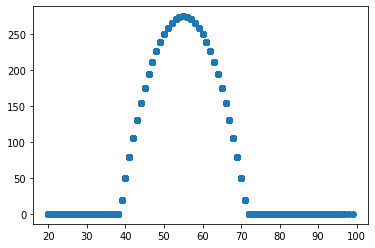

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

df['Risk_Variable'] = df.DrivAge.apply(lambda x: 0 if (- x**2. + 110.*x - 2750. < 0) else (- x**2. + 110.*x - 2750.))
plt.scatter(df.DrivAge, df.Risk_Variable)
plt.show()

**Переменные, сочетающие Gender, DrivAge и MariStat.** 

In [0]:
df['Gender_DrivAge'] = df.Gender * df.DrivAge

In [0]:
df['Gender_DrivAge_roll_1000'] = df['Gender_DrivAge'].rolling(window=1000).mean()
df['Gender_DrivAge_roll_10000'] = df['Gender_DrivAge'].rolling(window=10000).mean()

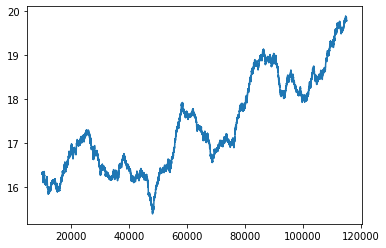

In [67]:
df['Gender_DrivAge_roll_10000'].plot()

In [0]:
df['Gender_DrivAge_MariStat'] = df.Gender * df.DrivAge * df.MariStat

In [0]:
df['Gender_DrivAge_MariStat_roll_1000'] = df['Gender_DrivAge_MariStat'].rolling(window=1000).mean()
df['Gender_DrivAge_MariStat_roll_10000'] = df['Gender_DrivAge_MariStat'].rolling(window=10000).mean()

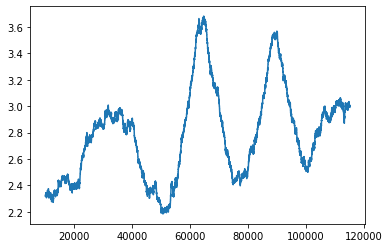

In [70]:
df['Gender_DrivAge_MariStat_roll_10000'].plot()

**Переменные, сочетающие HasKmLimit, BonusMalus, VehUsage_Private, VehUsage_Professional.**

In [0]:
df['HasKmLimit_BonusMalus_VehUsage_Professional'] = df.HasKmLimit * df.BonusMalus * df.VehUsage_Professional
df['HasKmLimit_BonusMalus_VehUsage_Private'] = df.HasKmLimit * df.BonusMalus * df.VehUsage_Private
df['HasKmLimit_VehUsage_Private'] = df.HasKmLimit * df.VehUsage_Private
df['HasKmLimit_VehUsage_Professional'] = df.HasKmLimit * df.VehUsage_Professional

In [0]:
df['HasKmLimit_BonusMalus_VehUsage_Professional_roll_1000'] = df['HasKmLimit_BonusMalus_VehUsage_Professional'].rolling(window=1000).mean()
df['HasKmLimit_BonusMalus_VehUsage_Professional_roll_10000'] = df['HasKmLimit_BonusMalus_VehUsage_Professional'].rolling(window=10000).mean()

df['HasKmLimit_BonusMalus_VehUsage_Private_roll_1000'] = df['HasKmLimit_BonusMalus_VehUsage_Private'].rolling(window=1000).mean()
df['HasKmLimit_BonusMalus_VehUsage_Private_roll_10000'] = df['HasKmLimit_BonusMalus_VehUsage_Private'].rolling(window=10000).mean()

df['HasKmLimit_VehUsage_Private_roll_1000'] = df['HasKmLimit_VehUsage_Private'].rolling(window=1000).mean()
df['HasKmLimit_VehUsage_Private_roll_10000'] = df['HasKmLimit_VehUsage_Private'].rolling(window=10000).mean()

df['HasKmLimit_VehUsage_Professional_roll_1000'] = df['HasKmLimit_VehUsage_Professional'].rolling(window=1000).mean()
df['HasKmLimit_VehUsage_Professional_roll_10000'] = df['HasKmLimit_VehUsage_Professional'].rolling(window=10000).mean()

Train/test split

In [73]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'CountPredicted', 'AvgClaimPredicted', 'BurningCost'], axis=1), df.ClaimInd, test_size=0.3, random_state=1)
x_valid_1, x_test_1, y_valid_1, y_test_1 = train_test_split(x_test_1, y_test_1, test_size=0.5, random_state=1)

h2o_train_1 = h2o.H2OFrame(pd.concat([x_train_1, y_train_1], axis=1))
h2o_valid_1 = h2o.H2OFrame(pd.concat([x_valid_1, y_valid_1], axis=1))
h2o_test_1 = h2o.H2OFrame(pd.concat([x_test_1, y_test_1], axis=1))

h2o_train_1["ClaimInd"] = h2o_train_1["ClaimInd"].asfactor()
h2o_valid_1["ClaimInd"] = h2o_valid_1["ClaimInd"].asfactor()
h2o_test_1["ClaimInd"] = h2o_test_1["ClaimInd"].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [74]:
glm_binomial_1 = H2OGeneralizedLinearEstimator(family = "binomial", link = "Logit", nfolds=5)
glm_binomial_1.train(y="ClaimInd", x = h2o_train_1.names[1:-1], training_frame = h2o_train_1, validation_frame = h2o_valid_1, weights_column = "Exposure")

glm_binomial_1.cross_validation_metrics_summary().as_data_frame().loc[15][0:2]

glm Model Build progress: |███████████████████████████████████████████████| 100%


        null_deviance
mean         5465.783
Name: 15, dtype: object

In [75]:
glm_binomial_1._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-1.278156,-1.943289
1,LicAge,-0.000208,-0.033125
2,Gender,-0.172057,-0.083318
3,MariStat,-0.075423,-0.026970
4,DrivAge,-0.026866,-0.402122
5,HasKmLimit,-0.358605,-0.111427
6,BonusMalus,0.005748,0.086664
7,OutUseNb,0.072467,0.048618
8,RiskArea,0.012847,0.028424
9,VehUsage_Private,-0.133803,-0.063458


In [76]:
train_1_pred = glm_binomial.predict(h2o_train_1).as_data_frame()
valid_1_pred = glm_binomial.predict(h2o_valid_1).as_data_frame()
test_1_pred = glm_binomial.predict(h2o_test_1).as_data_frame()

train_accuracy_score = accuracy_score(y_train_1, train_1_pred['predict'], normalize=True)
valid_accuracy_score = accuracy_score(y_valid_1, valid_1_pred['predict'], normalize=True)
test_accuracy_score = accuracy_score(y_test_1, test_1_pred['predict'], normalize=True)

train_f1_score = f1_score(y_train_1, train_1_pred['predict'], average='binary')
valid_f1_score = f1_score(y_valid_1, valid_1_pred['predict'], average='binary')
test_f1_score = f1_score(y_test_1, test_1_pred['predict'], average='binary')

train_confusion_matrix = confusion_matrix(y_train_1, train_1_pred['predict'])
valid_confusion_matrix = confusion_matrix(y_valid_1, valid_1_pred['predict'])
test_confusion_matrix = confusion_matrix(y_test_1, test_1_pred['predict'])

print(f'Accuracy score for train data = {train_accuracy_score:.4f},' 
      f'\nAccuracy score for valid = {valid_accuracy_score:.4f},' 
      f'\nAccuracy score for test = {test_accuracy_score:.4f}',
      f'\n-------------------------------------------------'
      f'\nF1 score for train data = {train_f1_score:.4f},'
      f'\nF1 score for valid = {valid_f1_score:.4f},'
      f'\nF1 score for test = {test_f1_score:.4f}',
      f'\n-------------------------------------------------'
      f'\nConfusion matrix for train data: \n{train_confusion_matrix}',
      f'\nConfusion matrix for valid data: \n{valid_confusion_matrix}',
      f'\nConfusion matrix for test data: \n{test_confusion_matrix}')

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Accuracy score for train data = 0.5353,
Accuracy score for valid = 0.5377,
Accuracy score for test = 0.5369 
-------------------------------------------------
F1 score for train data = 0.1846,
F1 score for valid = 0.1861,
F1 score for test = 0.1857 
-------------------------------------------------
Confusion matrix for train data: 
[[38910 34063]
 [ 3395  4240]] 
Confusion matrix for valid data: 
[[8374 7290]
 [ 696  913]] 
Confusion matrix for test data: 
[[8363 7286]
 [ 713  912]]


Добавление новых переменных не изменило значения метрики null_deviance. Увы!